In [1]:
# Something is wrong with jupyterlabs execution path
import os
os.chdir(os.path.dirname(os.path.abspath(".")))

# CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [167]:
from ConvLSTM import Seq2Seq
from DatasetOperations import stack_frames, SLADataset
import tabulate
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader
import xarray as xr
from datetime import date
from pathlib import Path
from typing import Type, Callable, List, Tuple
from Models import _types
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print(f"Using: 'cuda:{torch.cuda.current_device()}'")
else:
    print("Using: cpu")
    DEVICE = torch.device("cpu")

BASEPATH = Path(r"Data/Grids/")
%load_ext autoreload
%autoreload 2

Using: 'cuda:0'
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyperparameters

In [3]:
BACTH_SIZE = 5
SEQ_LEN = 3
PRED_TIME = 30
EPOCHS = 20

TRAIN_END = np.array(date(2014, 1, 1)).astype("datetime64[ns]")
TEST_END = np.array(date(2019, 1, 1)).astype("datetime64[ns]")

# Setup data

In [4]:
with xr.open_dataset(BASEPATH / "without_polar_v5_mss21.nc", engine="netcdf4") as file:
    sla = file['sla21'].data
    times = file['time'].data
    lat = file['Latitude'].data
    lon = file['Longitude'].data

In [5]:
train_features = sla[times <= TRAIN_END]
validation_features = sla[(times > TRAIN_END) & (times <= TEST_END)]
test_features = sla[times > TEST_END]

In [6]:
# Training Data Loader
train_loader = DataLoader(SLADataset(train_features, SEQ_LEN, PRED_TIME, fill_nan = 99), shuffle = False, batch_size = BACTH_SIZE)
validation_loader = DataLoader(SLADataset(validation_features, SEQ_LEN, PRED_TIME, fill_nan = 99), shuffle = False, batch_size = BACTH_SIZE)
test_loader = DataLoader(SLADataset(test_features, SEQ_LEN, PRED_TIME, fill_nan = 99), shuffle = False, batch_size = BACTH_SIZE)

# Get a batch
input_features, result, result_mask = next(iter(train_loader))

In [7]:
frame_size = tuple(input_features.shape[-2:])

In [17]:
#(batch_size, seq_len, num_channels, height, width)
tabulate.tabulate(
    [
        ["Sizes" ,"batch_size", "num_channels", "sequence length", "y_size", "x_size"],
        ["Input", *input_features.shape],
        ["Output", *result.shape[:1], None, None, *result.shape[1:]],
        ["Mask", *result_mask.shape[:1], None, None, *result_mask.shape[1:]]
    ],
    tablefmt='html'
)

Sizes,batch_size,num_channels,sequence length,y_size,x_size
Input,5,1,3,129,360
Output,5,,,129,360
Mask,5,,,129,360


# Loss function

In [18]:
loss_function = Callable[[torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]
def create_masked_loss_function(loss_module: Type[nn.modules.loss._Loss]) -> loss_function:
    """Constructs a masked loss function based on the loss module"""
    loss_function = loss_module()
    def masked_loss_function(output: torch.Tensor, target: torch.Tensor, masked: torch.Tensor) -> torch.Tensor:
        """
        Maskes the output and target based on the mask.
        The mask is True where the values should be ignored.
        """
        masked_output = output[~masked]
        masked_target = target[~masked]
        return loss_function(masked_output, masked_target)
    return masked_loss_function

In [19]:
criterion = create_masked_loss_function(nn.MSELoss)

# Train validation loop

In [170]:
def predict(model: nn.Module, loader: DataLoader, frame_size: Tuple[int, int], device: torch.device) -> Tuple[_types.float_like, _types.float_like]:
    """Makes a prediction for each batch in the loader an saves it in a tensor"""
    result = np.zeros((len(loader.dataset), *frame_size))
    targets = np.zeros((len(loader.dataset), *frame_size))
    model.eval()
    current_idx = 0
    with torch.no_grad():
        for features, target, mask in loader:
            features = features.to(device)
            target = target.to(device)
            mask = mask.to(device)

            # Predict
            output = model(features).squeeze(1)
            
            # Mask array
            output[mask] = np.nan
            target[mask] = np.nan

            # Save predictions and targets
            batch_size = output.size(0)
            result[current_idx:current_idx + batch_size] = output.cpu().detach().numpy()
            targets[current_idx:current_idx + batch_size] = target.cpu().detach().numpy()
            current_idx +=  batch_size
    return result, targets

def validate(model: nn.Module, loader: DataLoader, criterion: loss_function, device: torch.device) -> float:
    """Computes the criterion for the model and loader in evaluation mode"""
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for features, target, mask in loader:
            features = features.to(device)
            target = target.to(device)
            mask = mask.to(device)

            # Predict
            output = model(features)
            
            # Compute and add loss
            val_loss += criterion(output.squeeze(1), target, mask).item()

    # Compute average loss
    return val_loss / len(loader)

def train(
    model: nn.Module,
    loader: DataLoader,
    criterion: loss_function,
    optimizer: torch.optim.Optimizer,
    device: torch.device
) -> float | None:
    """Traines the model based on the criterion and loader"""
    train_loss = 0
    model.train()
    for features, target, mask in train_loader:
        features = features.to(device)
        target = target.to(device)
        mask = mask.to(device)
        
        # Predict
        output = model(features)
        
        # Compute loss and apply backpropagation
        loss = criterion(output.squeeze(1), target, mask)
        loss.backward()
        
        # Optimize
        optimizer.step()
        optimizer.zero_grad()
        
        # Save loss
        train_loss += loss.item()
        if np.isnan(train_loss):
            return None

    # Compute average loss
    return train_loss / len(loader)

def train_validation_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: loss_function,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: torch.device
) -> Tuple[List[int], List[float], List[float]]:
    """ Trains and evaluates the model at each epoch"""
    training_loss = []
    validation_loss = []
    epoch_number = []
    for epoch in range(1, num_epochs + 1):
        # Train model
        train_loss = train(model, train_loader, criterion, optimizer, device)
        if train_loss is None:
            print("Found nan values")
            return
        
        # Compute validation loss
        val_loss = validate(model, val_loader, criterion, device)
        
        # Save losses
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        epoch_number.append(epohc)
        
        # Print
        print(f"Epoch: {epoch} Training Loss: {np.sqrt(train_loss)*100:.2f} cm Validation Loss: {np.sqrt(val_loss)*100:.2f} cm")
    return epoch_number, training_loss, validation_loss

# Setup model and train model

In [22]:
model = Seq2Seq(
    num_channels = 1,
    num_kernels = 32,
    kernel_size = (3, 3),
    padding = (1, 1),
    activation = nn.ReLU(), 
    frame_size = frame_size,
    num_layers = 2,
    device = DEVICE
).to(DEVICE)

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-6)

# Train the model

In [23]:
train_validation_loop(model, train_loader, validation_loader, criterion, optimizer, EPOCHS, DEVICE)

Epoch:1 Training Loss: 38.56cm Validation Loss: 18.62cm
Epoch:2 Training Loss: 12.99cm Validation Loss: 9.11cm
Epoch:3 Training Loss: 6.86cm Validation Loss: 5.20cm
Epoch:4 Training Loss: 4.04cm Validation Loss: 3.23cm
Epoch:5 Training Loss: 2.58cm Validation Loss: 2.20cm
Epoch:6 Training Loss: 1.83cm Validation Loss: 1.66cm
Epoch:7 Training Loss: 1.43cm Validation Loss: 1.38cm
Epoch:8 Training Loss: 1.22cm Validation Loss: 1.22cm
Epoch:9 Training Loss: 1.09cm Validation Loss: 1.11cm
Epoch:10 Training Loss: 1.01cm Validation Loss: 1.03cm
Epoch:11 Training Loss: 0.95cm Validation Loss: 0.97cm
Epoch:12 Training Loss: 0.91cm Validation Loss: 0.94cm
Epoch:13 Training Loss: 0.88cm Validation Loss: 0.91cm
Epoch:14 Training Loss: 0.86cm Validation Loss: 0.89cm
Epoch:15 Training Loss: 0.84cm Validation Loss: 0.88cm
Epoch:16 Training Loss: 0.83cm Validation Loss: 0.87cm
Epoch:17 Training Loss: 0.83cm Validation Loss: 0.86cm
Epoch:18 Training Loss: 0.82cm Validation Loss: 0.86cm
Epoch:19 Trainin

# Inference

In [157]:
# Make predictions
loader = validation_loader
outputs, targets = predict(model, loader, frame_size, DEVICE)

In [117]:
extent = [lon[0].min() - 0.5, lon[0].max() + 0.5, lat[:,0].min() - 0.5, lat[:,0].max() + 0.5]

## One sample comparisions

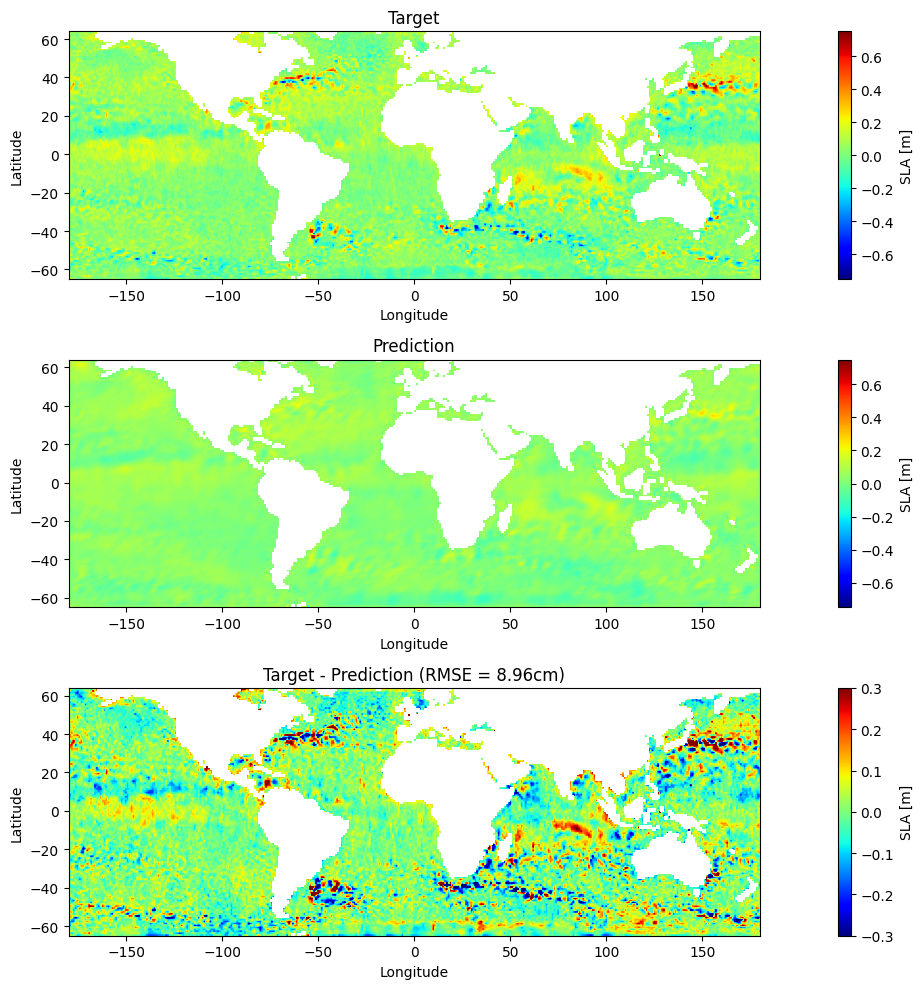

In [175]:
idx = 0
vmin = -0.75
vmax = 0.75
cmap = 'jet'

vmin_diff = -0.3
vmax_diff = 0.3

diff_data = targets[idx] - outputs[idx]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))


fig, axes = plt.subplots(3, 1, figsize=(16,10))
im_target = axes[0].imshow(targets[idx], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(outputs[idx], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title("Target")
axes[1].set_title("Prediction")
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")

plt.tight_layout()
plt.show()

## RMSE average temporal

In [191]:
diffs = targets - outputs
rmses = np.full(diffs.shape[1:], np.nan)
for lat_idx in range(targets.shape[1]):
    for lon_idx in range(targets.shape[2]):
        pixel_diffs = diffs[:, lat_idx, lon_idx]
        pixel_diffs_nonan = pixel_diffs[~np.isnan(pixel_diffs)]
        if len(pixel_diffs_nonan) == 0:
            continue
        rmses[lat_idx, lon_idx] = np.sqrt(pixel_diffs_nonan @ pixel_diffs_nonan/len(pixel_diffs_nonan))

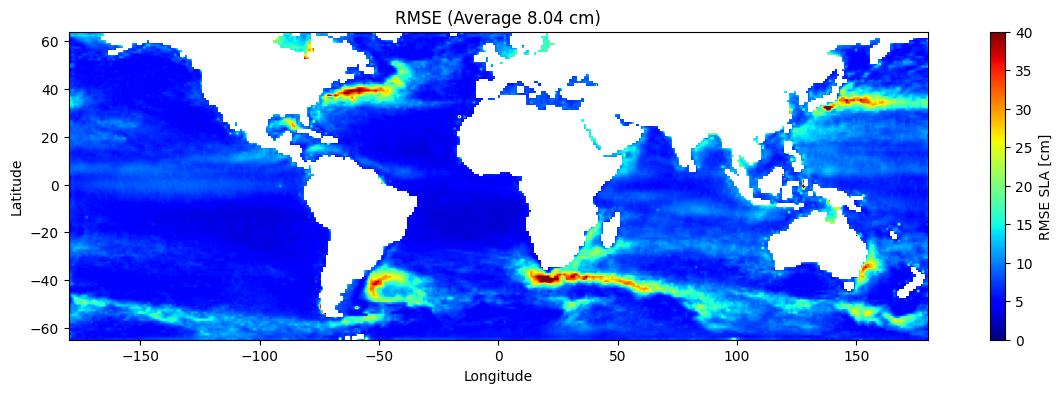

In [209]:
vmin = 0
vmax = 40
cmap = 'jet'

fig, ax = plt.subplots(1, 1, figsize=(16,4))
im_rms = ax.imshow(rmses * 100, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_title(f"RMSE (Average {np.nanmean(rmses)*100:.2f} cm)")
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
cax = fig.colorbar(im_rms)
cax.ax.set_ylabel("RMSE SLA [cm]")
plt.show()